<table>
    <tr>
        <td><img src="house_read.gif" style="height:400px;"></td>
        <td><img src="house_generate.gif" style="height:400px;"></td>
    </tr>
    <tr>
        <td>Left: RNN learns to read house numbers</td>
        <td>Right: RNN learns to paint house numbers</td>
    </tr>
</table>


# Recurrent Neural Network (RNN)

Kevin J. Walchko, Phd

14 Jan 2021

---

Deep learning tries to mimic the human brain in some way.

| Netowrk                 | Supervised | Use Case |
|-------------------------|---|:-------------------|
| ANN                     | Y | regression and classification, learns long-term memory through backpropagation (e.g., adjust weights) |
| CNN                     | Y | computer vision due to the use of convoution layers and leverages backpropagation |
| RNN                     | Y | time series analysis, introduces short-term memory |
| Self-Organizing Maps    | N | feature detection |
| Deep Boltzmann Machines | N | recommendation systems (e.g., Amazon cart) |
| AutoEncoders            | N | recommendation systems |

## RNN

- ANN and CNN, through backpropagtion learn *long-term memory*
- Add a temporal loop around the hidden layers and the neurons  are connecting to themselves to give it a *short-term memory*
    - In dynamic situation which constantly change, short-term memory helps link events (say in a movie) from one moment to another moment together in a way that makes sense. An ANN, given the entire movie at once, might be able to make sense of it, but in pieces, an RNN (with short-term memory) does a better job
    - Predict what text will appear next from some input

## Vanishing Gradient Problem

- Identified by Sepp Hochreiter in 1991
- Gradient decent tries to find the global minimum
- For RNN's, you have a $w_{rec}$ parameter that is adjusting your weights through time. You can get into a viscious cycle by NN weights (randomly initialized), as they propagate back through a network during training, their value becomes smaller (vanishing gradient). This means your NN may not be training properly.
    - $w_{rec}$ is small, then vanishing RNN, solutions:
        - weight initialization
        - echo state network
        - long short-term memory networks
    - $w_{rec}$ is large, then exploding RNN, solutions:
        - truncated backpropagation
        - penalties
        - gradient clipping
    

## Long Short-Term Memory (LSTM)

- Help solve the vanishing gradient problem
- Make the $w_{rec}$ = 1

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png)

- LSTM have a memory pipeline that flows through and prevents a memory gradient
- All of these lines are vectors
- Concatenate is really 2 vectors running in parallel
- Pointwise operations:
    - Valves (x) which can be opened or closed: forget, memory, and output
    - Joint (+) where memory maybe added through the flow
    - tanh, just an operation
- NN Layers:
    - Sigmoid ($\sigma$)
    - tanh


### Feature Scaling

$$
x_{stan} = \frac{x-mean(x)}{stddev(x)} \\
x_{norm} = \frac{x-\min(x)}{\max(x) - \min(x)}
$$

### Root Mean Squared Error

Often for Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.

```python
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
```

### Improve Performance

- More data
- More LSTM layers
- More neurons
- Increasing timesteps
- More indicators (things Google's stock price is dependent on)

## References

- Kirill Eremenko, Hadenlin de Ponteves, "Learn to create Deep Learning Algorithms in Python from two Machine Learning & Data Science experts", udemy.com
- Razvan Pascanu, 2013, [On the difficulty of training recurrent neural networks](http://www.jmlr.org/proceedings/papers/v28/pascanu13.pdf)
- Christopher Olah, 2015, [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    - [blog](http://colah.github.io/)
- Andrej Karpathy, 2015, [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- Andrej Karpathy, 2015, [Visualizing and Understanding Recurrent Networks](https://arxiv.org/pdf/1506.02078.pdf)
- [SuperDataScience](https://www.superdatascience.com/pages/deep-learning)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Get and Pre-Process Data

In [2]:
# load data
# Google stock price from 2012-2016
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [38]:
dataset_train.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


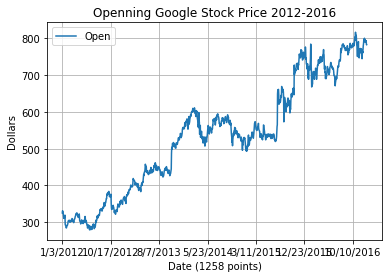

In [40]:
dataset_train.plot(
    x="Date", y="Open", 
    grid=True, 
    ylabel="Dollars",
    xlabel=f"Date ({len(dataset_train)} points)",
    title="Openning Google Stock Price 2012-2016"
);

>> X_train dimension size[batch,timesteps,inputdims] = (1198, 60, 1)


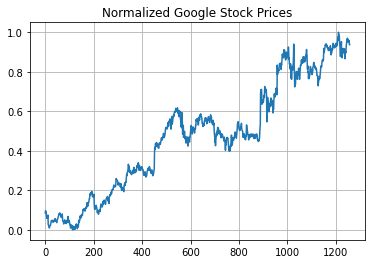

In [21]:
# get access to data point values
training_set = dataset_train.iloc[:, 1:2].values

# since we have a sigmoid acitivation function in the 
# output layer of the RNN, we should
# normalize our data
sc = MinMaxScaler(feature_range = (0, 1)) # set scaler to range [0,1]
training_set_scaled = sc.fit_transform(training_set) # now scale data

plt.plot(training_set_scaled)
plt.grid(True)
plt.title("Normalized Google Stock Prices");

# timesteps are very important, this sets how long the short-term
# memory is. Here we are going to have the RNN look at the preceeding
# 60 days worth of prices before predicting the next price. This
# number 60 is arrived at by testing different memory lengths
# and identifying the best number. Also, this is a sliding window
# of memory.
#
# create a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape the training data to be compatable with scikit-learn
# Expects [batch_size, timesteps, input_dimensions]
# here input_dimensions is 1 because there is only 1 stock price, but
# image Google's stockprice was dependant on Samsung (makes cellphone parts),
# we could add Samsung's stock prices in here too and have an input
# dimension of 2
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f">> X_train dimension size[batch,timesteps,inputdims] = {X_train.shape}")

## Building and Training the RNN

Here we will build an RNN with 4 LSTM layers with dropouts to prevent overfitting of our training data.

In [14]:
regressor = Sequential()

# add first layer with:
# units: number of lstm neurons/units, set to 50 do add high dimensionality to 
#        capture the complexity of the dataset
# return_sequence: building a stacked NN with multiple lstm layers
# dropout: drop the number of neurons, here we choose 20%, the 
#          means 10 neurons (50*0.2) are dropped during forward/backpropgation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# add 2nd LSTM and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# add 3rd LSTM with dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# add 4th LSTM with dropout regularisation
# Note, defaul is return_sequences = False
regressor.add(LSTM(units = 50)) 
regressor.add(Dropout(0.2))

# output layer
# Dense class gives us a fully connected NN with 1 dimensional output
regressor.add(Dense(units = 1))

# compile RNN
# could use RMSprop which Keras suggests for RNN, we 
# chose differently for no clear reason
# adam: stochastic gradient decent (safe choice)
# loss: MSE for calculating the error to update neuron 
#       weights in back propagation
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [15]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32);

Epoch 1/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0302
Epoch 2/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0063
Epoch 3/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0054
Epoch 4/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0047
Epoch 6/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0058
Epoch 7/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0048
Epoch 8/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0052
Epoch 9/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 6s 152ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0039
Epoch 12/100
38/38 [==============================] - 6s 154ms/step - loss: 0.0040
Epoch 13/100


## Making Predictions

### Getting the real stock price of 2017

In [16]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


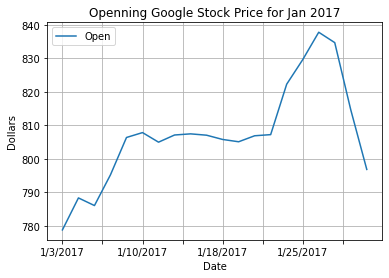

In [18]:
dataset_test.plot(
    x="Date", y="Open", 
    grid=True, 
    ylabel="Dollars",
    title="Openning Google Stock Price for Jan 2017"
);

In [19]:
real_stock_price = dataset_test.iloc[:, 1:2].values

# need to scale input test data
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test) # predict
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # de-scale

### Visualising the results

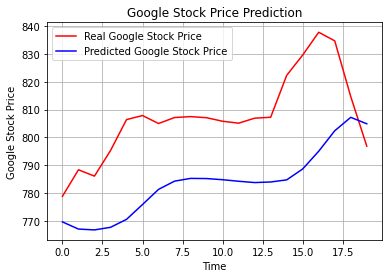

In [20]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.grid(True)
plt.legend()

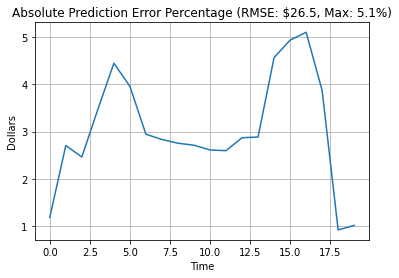

In [46]:
# so it looks like a lot of error, but notice it really isn't that much
# since we are maybe $40 off on a price of $850. Let's look at the
# percent of error
import math
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
err = 100*np.abs(real_stock_price - predicted_stock_price)/real_stock_price
err = err.ravel()
plt.plot(err)
plt.title(f'Absolute Prediction Error Percentage (RMSE: ${rmse:0.1f}, Max: {max(err):0.1f}%)')
plt.xlabel('Time')
plt.ylabel('Dollars')
plt.grid(True)